# Data Engineering for Simple Recommendation

In the previous notebook I did some exploratory data analysis to better understanding my data and make informed decisions about the data I am allowing to be used in my recommender.

I decided not to user and subjective user information in my recommender and instead focus entirely on implicit information (`price`, `spirit_style` and `taste`).  Not every scotch had a recorded `taste` field on the website so I will loose several of my scotches.  Additionally, I decided that this recommender should avoid ridiculously overpriced scotch (you know stuff that costs as much as a car).

This notebook will divide that data up that way that I want as well as create to dataframes to be used going forward.  One I am referring to as "data", which will have the data needed for the recommendation to take place and one I'll refer to as "info", this is the information associated each scotch that will be the output to the user.

In [1]:
import pandas as pd
import numpy as np

In [4]:
# read in data
data = pd.read_csv('./data/simple_rec_data.csv')
data.drop('Unnamed: 0', axis = 1, inplace = True)

In [5]:
data.head()

,title,price,avg_rating,taste,score,brand,description,spirit_style,state,taste_list
0,A.D. Rattray Aberfeldy 18 Yr,99.99,-1.0,None,-1,A.D. Rattray,"Highlands, Scotland- Pleasant aromas of caram...",Single Malt,Highland,['none']
1,A.D. Rattray Auchroisk 22 Yr,139.99,-1.0,None,-1,A.D. Rattray,"Speyside, Scotland - This Auchroisk is quite ...",Single Malt,NaN,['none']
2,A.D. Rattray Aultmore 16 Year,97.99,-1.0,None,-1,A.D. Rattray,"Speyside, Scotland- Aroma of honey, ripe frui...",Single Malt,NaN,['none']
3,A.D. Rattray Ben Nevis 17Yr Single Cask Barrel...,99.99,-1.0,Delicate . Apple . Grass . Vanilla . Complex,-1,A.D. Rattray,NaN,Single Malt,Highland,"[' delicate', 'apple', 'grass', 'vanilla', 'co..."
4,A.D. Rattray Benriach 23 Yr,179.99,-1.0,None,-1,A.D. Rattray,"Speyside, Scotland- Rich aromas of honey and ...",Single Malt,NaN,['none']


In [8]:
# As expected, the taste_list list has been wrapped in a string via the pd.to_csv()
# I'll use the eval() function later to fix this
data.iloc[0]['taste_list']

"['none']"

In [12]:
# spliting data up into info which will be the returned output of the recommender and 
# data which will be the input to the recommender to calculate similarity.
df_info = data[['title','price','taste','brand','description','spirit_style','state']]
df_data = data[['title','price','spirit_style','taste_list']]

In [15]:
# setting index to the name of the scotch
df_info.set_index('title', inplace = True)
df_data.set_index('title', inplace = True)

In [19]:
df_data.shape

(1428, 3)

In [21]:
df_data['taste_list'].value_counts()[0]

608

After removing all of the `['none']` values or those observations that do not have tasting notes, I'll still have ~800 scotches on hand, which I think is fair considering I've had like a total of seven different scotches before.

In [24]:
# getting rid of all those "['none']"s
df_data = df_data[df_data['taste_list'] != "['none']"]

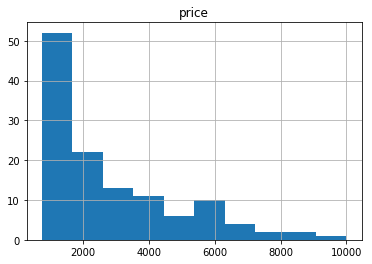

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

df_data[(df_data['price'] > 750) & (df_data['price'] < 10000) ].hist();

I still want this to be a realistic recommender that the average scotch drinker will use, so i'm going to remove those dumb expensive scotches.  Although, I'm having difficulty with the threshold... 
- I think for my initial trial I'll do double of my 3 IQR value outliers discovered in the EDA notebook.  
    - 3 IQR outliers were about `$750.00` so my limit will be `$1500.00`

In [31]:
df_data = df_data[df_data['price'] < 1500]

In [32]:
df_data.describe()

,price
count,705.000000
mean,219.987163
std,276.404104
min,8.990000
25%,52.990000
50%,109.990000
75%,259.990000
max,1499.990000


Now that I have my subset...
- Standardize and potentially deskew the `price`.
- Dummy the `spirit_style` column.
- Vectorize the `taste_list` column.

In [34]:
# eyes on check
df_data.head()

,price,spirit_style,taste_list
title,,,
A.D. Rattray Ben Nevis 17Yr Single Cask Barrel Select,99.99,Single Malt,"[' delicate', 'apple', 'grass', 'vanilla', 'co..."
A.D. Rattray Girvan 1964 50 Yr,899.99,Single Malt,"[' rich', 'orange', 'chocolate', 'nut', 'long ']"
A.D. Rattray Glen Elgin 1995 Single Barrel Select,119.99,Single Malt,"[' medium', 'vanilla', 'spice', 'long ']"
A.D. Rattray Stronachie 12yr,49.99,Single Malt,"[' peat', 'nut ']"
Aberfeldy 12 yo,32.99,Single Malt,"[' rich', 'spice', 'honey', 'long ']"


In [39]:
# apply eval() to convert the string object to a list
df_data['taste_list'] = df_data['taste_list'].apply(eval) 

In [41]:
# verify success of eval
df_data.iloc[0]['taste_list']

[' delicate', 'apple', 'grass', 'vanilla', 'complex ']

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

In [43]:
# convert the list of works into a single string with space separators.
df_data['taste_vector'] = df_data['taste_list'].apply(lambda x : ' '.join(x))

In [44]:
# use count vectorizer to get the notes dataframe
tvec = CountVectorizer()

notes_df = pd.DataFrame(tvec.fit_transform(df_data['taste_vector']).todense(),
             columns = tvec.get_feature_names())

In [106]:
# check out the count vector
notes_df.head(2)

,almond,amoroso,anise,apple,apricot,baked,balanced,barley,berry,blackberry,...,sweet,tar,toast,tobacco,toffee,tropical,vanilla,walnut,wood,yeast
name,,,,,,,,,,,,,,,,,,,,,
A.D. Rattray Ben Nevis 17Yr Single Cask Barrel Select,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
A.D. Rattray Girvan 1964 50 Yr,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
# remove seed column as it is perfectly correlated to mustard and thus not necessary.
notes_df.drop('seed', axis =1, inplace = True)

## Weight of Price

I want to have price be a consideration of the recommendation, but I don't want it to be too influential.  This is difficult because I do not have a normal distribution and it is very skewed to the right. Even though I've removed significant outliers, these expensive scotches could still be very much outside the standard distribution and thus a standardized value of 3 could exist which may put it quite far outside the expectation and really penalize it.

- I can use a de-skewing tactic by taking the log in combination with standardization, but i'm still uncertain in which order I should do this or if I even absolutely should de-skew.

In [67]:
# using log to convert price into a logrithmic value
# log1p i natural log using Euler's Number
df_data['price_logged'] = np.log1p(df_data['price'])

In [54]:
# scaling data, applying standard scaler to normal price and the logged transformation
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

df_data['price_scaled'] = ss.fit_transform(df_data['price'].values.reshape(-1,1))
df_data['price_logged_scaled'] = ss.fit_transform(df_data['price_logged'].values.reshape(-1,1))


In [59]:
# create a column that logs the scaled price. 
df_data['price_scaled_logged'] = np.log1p(df_data['price_scaled'])

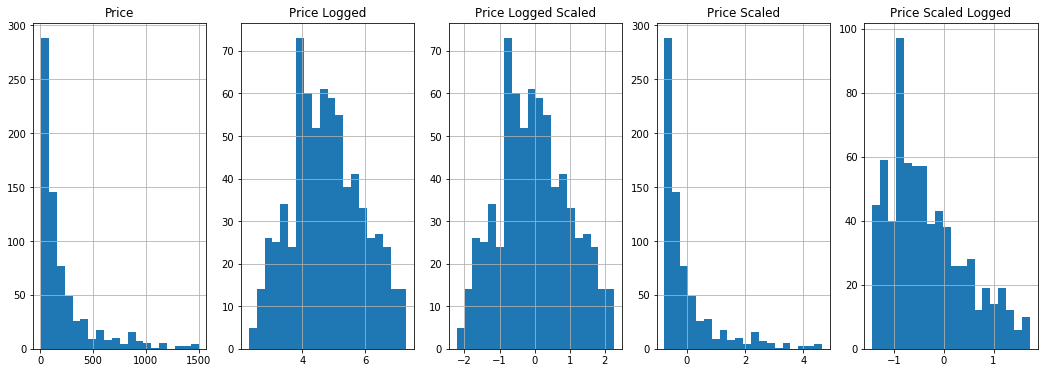

In [69]:
# Check out the distributions of the 5 price columns relative to scaling and de-skewing.
plt.figure(figsize = (18, 6))
plt.subplot(1,5,1)
df_data['price'].hist(bins = 20)
plt.title('Price')

plt.subplot(1,5,2)
df_data['price_logged'].hist(bins = 20)
plt.title('Price Logged')

plt.subplot(1,5,3)
df_data['price_logged_scaled'].hist(bins = 20)
plt.title('Price Logged Scaled')

plt.subplot(1,5,4)
df_data['price_scaled'].hist(bins = 20)
plt.title('Price Scaled')

plt.subplot(1,5,5)
df_data['price_scaled_logged'].hist(bins = 20)
plt.title('Price Scaled Logged')

In [70]:
df_data['price'].describe()

count     705.000000
mean      219.987163
std       276.404104
min         8.990000
25%        52.990000
50%       109.990000
75%       259.990000
max      1499.990000
Name: price, dtype: float64

Now I have a new consideration.  
- `Price Logged Scaled` would make price a **more** important feature.
    - Seems like it will penalize lower price scotches 
- `Price Scaled Logged` would make price a **less** important feature.


_I think im going to use just `Price Scaled`._

_Ideally, I would like price to be an automatic consideration in that if a user puts in lower priced scotches then price will be more important for the recommendation, however if they put in higher price scotches than price will be less relevant as someone that enjoyed a `$150` bottle of scotch would be fine purchasing a `$40` bottle of scotch however the inverse of that is probably not true._

_Later on I decide the my function has an argument that dictates the importance of price to the user such that is is "Not Important" (feature is removed), "Somewhat important" (scaler of 1.5 applied) and "Very Important" (Scaler of 2.0 applied)._

In [74]:
# dummy the spirit style variable
df_data = pd.concat([df_data, pd.get_dummies(df_data['spirit_style'])], axis =1)

In [78]:
df_data['spirit_style'].value_counts()

Single Malt       602
Blended Scotch     92
Name: spirit_style, dtype: int64

Single malt is the overwhelming default thus I'll drop that column and just utilize the Blended Scotch dummy column.  
- Given that `Blended Scotch` and `Single Malt` columns express the same information, I only need to utilize one of them.  That being said, if I wanted this spirit style to be more impactful, I could leave both of the columns in or double the values in the one column I kept.  This will double their distances between a single malt scotch compared to a blended scotch.

In [81]:
# confirming shapes of dataframes before joining
df_data.shape

(705, 11)

In [80]:
notes_df.shape

(705, 79)

In [86]:
# setting name to index for easier join
notes_df['name'] = df_data.index
notes_df.set_index('name', inplace = True)

In [91]:
# concatting frames
data_df = pd.concat([df_data, notes_df], axis =1,)

In [92]:
# Data Validation
data_df.head()

,price,spirit_style,taste_list,taste_vector,price_logged,price_scaled,price_logged_scaled,prices_scaled_logged,price_scaled_logged,Blended Scotch,...,sweet,tar,toast,tobacco,toffee,tropical,vanilla,walnut,wood,yeast
A.D. Rattray Ben Nevis 17Yr Single Cask Barrel Select,99.99,Single Malt,"[ delicate, apple, grass, vanilla, complex ]",delicate apple grass vanilla complex,4.615022,-0.434445,-0.149031,-0.569948,-0.569948,0,...,0,0,0,0,0,0,1,0,0,0
A.D. Rattray Girvan 1964 50 Yr,899.99,Single Malt,"[ rich, orange, chocolate, nut, long ]",rich orange chocolate nut long,6.803494,2.461923,1.811362,1.241824,1.241824,0,...,0,0,0,0,0,0,0,0,0,0
A.D. Rattray Glen Elgin 1995 Single Barrel Select,119.99,Single Malt,"[ medium, vanilla, spice, long ]",medium vanilla spice long,4.795708,-0.362036,0.012825,-0.449473,-0.449473,0,...,0,0,0,0,0,0,1,0,0,0
A.D. Rattray Stronachie 12yr,49.99,Single Malt,"[ peat, nut ]",peat nut,3.931630,-0.615468,-0.761200,-0.955728,-0.955728,0,...,0,0,0,0,0,0,0,0,0,0
Aberfeldy 12 yo,32.99,Single Malt,"[ rich, spice, honey, long ]",rich spice honey long,3.526066,-0.677016,-1.124496,-1.130152,-1.130152,0,...,0,0,0,0,0,0,0,0,0,0


## Slice the data and save to CSV

In [99]:
# subsetting my data to the columns wanted for recommendation
rec_cols = ['price_scaled','Blended Scotch']
rec_cols.extend(list(notes_df.columns))
rec_df = data_df[rec_cols]


In [101]:
rec_df.to_csv('./data/simple_rec_model_data.csv', )

In [104]:
df_info.to_csv('./data/simple_rec_info_data.csv')